<a href="https://colab.research.google.com/github/kenza-c/M2BIGDATA/blob/main/REC_VF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import transformers
from transformers import pipeline
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
import random

In [8]:
from spacy.lang.fr.stop_words import STOP_WORDS

In [9]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 50.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [10]:
df_reclamations=pd.read_excel("/content/Rec_kenza.xlsx")

In [11]:
df_reclamations.head()

,REFERENCE,DATREC,DAT_ENRGREC,NUMCPT,MAIL_CLT,MAIL_ENV_CLT,FICHIERJOINT,UTILISATEUR,SUPPORT,DATOPER,...,DESCRIPTION,MOTIF_CLOTURE,TYPE_RECLAM,DATTRAIT,DATE_CLOTURE,SORT,DESCRIPTION_SORT,MOTIF_CLO,SEGMENT_NMR,SPECIFICITE
0,R/00898474/2024,2024-01-01,2024-01-02,NaN,NaN,NaN,NaN,2074,SITE WEB,2024-01-02 09:49:03,...,"BONJOUR,_x000D_\n_x000D_\nJE N ARRIVE PAS À ME...",NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...,RECLAMATION,2024-01-04 10:35:32,2024-01-04,Validation traitement,"POUR OBTENIR LE NOUVEAU MOT DE PASSE, NOUS VOU...",NaN,NOUVEAU CLIENT,4
1,R/00898546/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,NaN,2098,MAIL,2024-01-02 11:42:25,...,BONJOUR_x000D_\n_x000D_\nAPUREMENT COMPTE CART...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-01-02 13:34:58,2024-01-03,Validation traitement,nf,NaN,S1 EXCELLENCE,PRIVILEGE
2,R/00898578/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,4937.pdf,2021,COURRIER,2024-01-02 14:23:46,...,ANNULATION ENCAISSEMENT CHQ VERS SUR CPTE EN D...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-01-02 14:31:21,2024-01-03,Validation traitement,od validée merci de clôturer le compte,NaN,NOUVEAU CLIENT,4
3,R/00905876/2024,2024-01-02,2024-02-01,NaN,NaN,NaN,CH2000.pdf,2837,VISITE,2024-02-01 10:14:30,...,DEBLOC AGE PROVISION CH REJETE PAP _x000D_\n_x...,OD valide au niveau DELTA. Reclamation traitee...,RECLAMATION,2024-02-01 14:54:58,2024-02-02,Validation traitement,nf,NaN,S4 AVENIR,NaN
4,R/00898673/2024,2024-01-02,2024-01-02,NaN,NaN,NaN,NaN,4724,VISITE,2024-01-02 15:34:55,...,AC2 REAL TIME BLOQUÉ MERCI D'INTERVENIR,NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...,RECLAMATION,2024-01-04 14:05:55,2024-01-04,Validation traitement,Abonnement débloqué. Un nouveau mot de passe v...,NaN,S2 PREMIUM,PRESTIGE


In [12]:
df_clients = pd.read_csv("/content/table_client.txt",delimiter = ';')
# Éliminer les lignes qui n'ont pas d'ID
df_clients1 = df_clients.dropna(subset=['Id_client'])

# Réinitialiser l'index après avoir supprimé des lignes
df_clients2 = df_clients1.reset_index(drop=True)

df_clients_VF = df_clients2.sample(n=3500)

In [13]:
df_clients_VF.head(50)

,Id_client,Tranche_age,Sexe,Nationalite,Situation_familiale,CSP,Secteur_activite,Type_marche,Type_personne,Ville,Code_postal,Pays,Statut_client,Agence_rattachement
18656,18657.0,46-55 ans,Homme,Tunisienne,Marié(e),Ouvrier,Administration publique,Particulier,Physique,Zaghouan,1200.0,Tunisie,Prospect,7.0
21020,21021.0,36-45 ans,Femme,Tunisienne,Marié(e),Cadre moyens,Intermediation financière,Professionnel,Morale,Béja,1000.0,Tunisie,Client,183.0
11952,11953.0,46-55 ans,Homme,Tunisienne,Célibataire,Commerçants - Habillement,Agroalimentaire,Services personnels,Morale,Tozeur,2200.0,Tunisie,Client,99.0
3076,3077.0,36-45 ans,Femme,Tunisienne,Célibataire,Retraité,Automobile,Professionnel,Morale,Sousse,1200.0,Tunisie,Prospect,217.0
782,783.0,56 ans et plus,Femme,Tunisienne,Divorcé(e),Cadre moyens,Police,Particulier,Physique,Kairouan,4000.0,Tunisie,Prospect,107.0
13370,13371.0,26-35 ans,Homme,Tunisienne,Marié(e),Professeur secondaire,Police,TPE PERSONNE PHYSIQUE,Morale,Gafsa,6000.0,Tunisie,Client,209.0
3683,3684.0,26-35 ans,Homme,Tunisienne,Divorcé(e),Employé,Activites hospitalières,Services personnels,Morale,Kébili,2080.0,Tunisie,Prospect,6.0
17347,17348.0,56 ans et plus,Homme,Tunisienne,Veuf(ve),Professeur secondaire,Commerce de gros d'habillement,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20295,20296.0,36-45 ans,Homme,Tunisienne,Divorcé(e),Ouvrier,Boulangerie/Patisserie,Services personnels,Morale,Kébili,9000.0,Tunisie,Client,32.0
11007,11008.0,18-25 ans,Femme,Tunisienne,Célibataire,Professeur primaire,Extraction de petrole brut,Services personnels,Morale,Mahdia,5000.0,Tunisie,Prospect,210.0


In [14]:
df_clients_VF.to_csv('df_clients_VF.csv', index=False)

In [15]:
client_ids = df_clients_VF['Id_client'].unique()

In [16]:
client_ids = np.repeat(client_ids, np.random.randint(1, 5, size=len(client_ids)))

In [17]:
if len(df_reclamations) < len(client_ids):
    client_ids = client_ids[:len(df_reclamations)]

df_reclamations['Id_client'] = client_ids

In [18]:
df_reclamations.to_csv('reclamations_modifie.csv', index=False)

In [19]:
new_client_ids = []

# Pour chaque id_client dans client_ids
for Id_client in client_ids:
    # Générer un nombre aléatoire entre 1 et 4
    num_reclamations = np.random.randint(1, 5)

    # Ajouter l'id_client à new_client_ids pour chaque réclamation
    new_client_ids.extend([Id_client] * num_reclamations)

# Si df_reclamations a moins de lignes que new_client_ids, nous allons réduire new_client_ids
if len(df_reclamations) < len(new_client_ids):
    new_client_ids = new_client_ids[:len(df_reclamations)]

df_reclamations['Id_client'] = new_client_ids

In [20]:
df_reclamations.to_csv('reclamations_modifie_V1.csv', index=False)

In [21]:
# Effectuer l'opération de fusion
df_clients_reclamations = pd.merge(df_clients, df_reclamations, on='Id_client', how='inner')

In [22]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [23]:
df_reclamations = df_reclamations.drop('MOTIF_CLO', axis=1)

In [24]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [25]:
# Extraire les lignes où statut_client est égal à 'Prospect'
df_prospect = df_clients_reclamations[df_clients_reclamations['Statut_client'] == 'Prospect']

In [26]:
# Enregistrer le DataFrame extrait dans un nouveau fichier csv
df_prospect.to_csv('prospect.csv', index=False)

In [27]:
print(df_clients_reclamations.describe())

          Id_client  Code_postal  Agence_rattachement  \
count   4499.000000  4265.000000          4265.000000   
mean   11356.389864  3908.049707           122.551934   
min       16.000000  1000.000000             1.000000   
25%     5409.000000  2080.000000            59.000000   
50%    11436.000000  3200.000000           128.000000   
75%    17368.000000  5100.000000           185.000000   
max    22739.000000  9000.000000           235.000000   
std     6640.372114  2328.043573            70.179846   

                              DATREC                    DAT_ENRGREC  NUMCPT  \
count                           4499                           4499     0.0   
mean   2024-02-07 15:53:48.717492736  2024-02-08 12:59:03.187374848     NaN   
min              2024-01-01 00:00:00            2024-01-02 00:00:00     NaN   
25%              2024-01-17 00:00:00            2024-01-17 00:00:00     NaN   
50%              2024-02-01 00:00:00            2024-02-02 00:00:00     NaN   
75%         

In [28]:
df_clients_reclamations.info

<bound method DataFrame.info of       Id_client     Tranche_age   Sexe Nationalite Situation_familiale  \
0          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
1          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
2          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
3          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
4          16.0  56 ans et plus  Homme  Tunisienne            Marié(e)   
...         ...             ...    ...         ...                 ...   
4494    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4495    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4496    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4497    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   
4498    22739.0       18-25 ans  Femme  Tunisienne          Divorcé(e)   

                         CSP  Secteur_activite    Type_marche Type_personne  \
0      Professeur secondaire          Services            TRE        Morale   
1      Professeur secondaire          Services            TRE        Morale   
2      Professeur secondaire          Services            TRE        Morale   
3      Professeur secondaire          Services            TRE        Morale   
4      Professeur secondaire          Services            TRE        Morale   
...                      ...               ...            ...           ...   
4494  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4495  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4496  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4497  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   
4498  Dirigeant d'entreprise  Banque/Assurance  Professionnel        Morale   

       Ville  ...                                        DESCRIPTION  \
0     Mahdia  ...                               BLOCAGE NON UTILISÉ    
1     Mahdia  ...  LA RELATION WEBANK N'ARRIVE PAS A CONSULTER LE...   
2     Mahdia  ...           RÉGULARISATION CPTE CARTE TECH DEBITEUR    
3     Mahdia  ...  BONOUR,_x000D_\n_x000D_\nPRIÈRE DE NOUS VALIDE...   
4     Mahdia  ...  BONJOUR _x000D_\n_x000D_\nPRIÈRE DE VALIDER L'...   
...      ...  ...                                                ...   
4494    Sfax  ...  REDRESSEMENT RETRAIT ESPECES EFFECTUE PAR ERRE...   
4495    Sfax  ...  RETARD DE TRAITEMENT DE CONTRAT D'HYPOTHÈQUE _...   
4496    Sfax  ...  BONJOUR,_x000D_\n_x000D_\nPRIERE DE DEBLOQUER ...   
4497    Sfax  ...  _x000D_\n_x000D_\nBONJOUR,_x000D_\n_x000D_\nPR...   
4498    Sfax  ...  BONJOUR,_x000D_\n_x000D_\nPRIERE DE DEBLOQUER ...   

                                          MOTIF_CLOTURE  TYPE_RECLAM  \
0     OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
1      NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...  RECLAMATION   
2     OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
3     OD non valide au niveau DELTA. Reclamation tra...  RECLAMATION   
4     OD non valide au niveau DELTA. Reclamation tra...  RECLAMATION   
...                                                 ...          ...   
4494  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4495   NOUS VOUS INFORMONS QUE VOTRE DEMANDE SOUS LA...  RECLAMATION   
4496  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4497  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   
4498  OD valide au niveau DELTA. Reclamation traitee...  RECLAMATION   

                DATTRAIT DATE_CLOTURE                   SORT  \
0    2024-02-09 13:45:59   2024-02-10  Validation traitement   
1    2024-02-09 10:23:57   2024-02-09  Validation traitement   
2    2024-02-09 10:11:37   2024-02-10  Validation traitement   
3    2024-02-09 11:11:03   2024-02-10       Manque documents   
4    2024-02-12 13:59:53   2024-02-13       Manque documents   
...             

In [29]:
df_clients_reclamations.dtypes

Id_client                     float64
Tranche_age                    object
Sexe                           object
Nationalite                    object
Situation_familiale            object
CSP                            object
Secteur_activite               object
Type_marche                    object
Type_personne                  object
Ville                          object
Code_postal                   float64
Pays                           object
Statut_client                  object
Agence_rattachement           float64
REFERENCE                      object
DATREC                 datetime64[ns]
DAT_ENRGREC            datetime64[ns]
NUMCPT                        float64
MAIL_CLT                      float64
MAIL_ENV_CLT                  float64
FICHIERJOINT                   object
UTILISATEUR                     int64
SUPPORT                        object
DATOPER                datetime64[ns]
OBSERVATION                    object
TYPDOC                         object
NUMDOC      

In [30]:
# Remplacer '56 ans et plus' par '56<=' dans la colonne Tranche_age
df_clients_reclamations['Tranche_age'] = df_clients_reclamations['Tranche_age'].replace('56 ans et plus', '56<=')

In [31]:
# Initialize the sentiment analysis model
sentiment_model = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [32]:
# Preprocess the data
def preprocess_data(text):
    # Replace any HTML tags with an empty string
    text = re.sub('<.*?>', '', text)
    # Replace any non-alphabetic characters with a space
    text = re.sub('[^a-zA-Z]', ' ', text)
    # Convert the text to lowercase
    text = text.lower()
    # Return the preprocessed text
    return text

In [33]:
# Preprocess the review text
df_clients_reclamations['DESC_CLEAN'] = df_clients_reclamations['DESCRIPTION'].apply(preprocess_data)

In [34]:
df_clients_reclamations['DESC_CLEAN']

0                                    blocage non utilis  
1       la relation webank n arrive pas a consulter le...
2                r gularisation cpte carte tech debiteur 
3       bonour  x   d   x   d  pri re de nous valider ...
4       bonjour  x   d   x   d  pri re de valider l   ...
                              ...                        
4494    redressement retrait especes effectue par erre...
4495    retard de traitement de contrat d hypoth que  ...
4496    bonjour  x   d   x   d  priere de debloquer la...
4497     x   d   x   d  bonjour  x   d   x   d  priere...
4498    bonjour  x   d   x   d  priere de debloquer la...
Name: DESC_CLEAN, Length: 4499, dtype: object

In [35]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [36]:
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity

    return sentiment

In [37]:
def analyze_sentiment(df, column, sentiment_func):
    df[column + '_sentiment'] = df[column].apply(sentiment_func)

    return df

In [38]:
df_clients_reclamations = analyze_sentiment(df_clients_reclamations, 'DESC_CLEAN', get_sentiment_textblob)

In [39]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [40]:
print(df_clients_reclamations.columns)

Index(['Id_client', 'Tranche_age', 'Sexe', 'Nationalite',
       'Situation_familiale', 'CSP', 'Secteur_activite', 'Type_marche',
       'Type_personne', 'Ville', 'Code_postal', 'Pays', 'Statut_client',
       'Agence_rattachement', 'REFERENCE', 'DATREC', 'DAT_ENRGREC', 'NUMCPT',
       'MAIL_CLT', 'MAIL_ENV_CLT', 'FICHIERJOINT', 'UTILISATEUR', 'SUPPORT',
       'DATOPER', 'OBSERVATION', 'TYPDOC', 'NUMDOC', 'CHARG_CLIENT',
       'DESCRIPTION', 'MOTIF_CLOTURE', 'TYPE_RECLAM', 'DATTRAIT',
       'DATE_CLOTURE', 'SORT', 'DESCRIPTION_SORT', 'MOTIF_CLO', 'SEGMENT_NMR',
       'SPECIFICITE', 'DESC_CLEAN', 'DESC_CLEAN_sentiment'],
      dtype='object')


In [41]:
# Add a new column called 'sentiment'
df_clients_reclamations['sentiment'] = 0.0

# Loop through each reclamation and calculate its sentiment score
for i, row in df_clients_reclamations.iterrows():
    text = row['DESC_CLEAN']
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    df_clients_reclamations.at[i, 'sentiment'] = sentiment_score

# Display the updated DataFrame
print(df_clients_reclamations.head())

   Id_client Tranche_age   Sexe Nationalite Situation_familiale  \
0       16.0        56<=  Homme  Tunisienne            Marié(e)   
1       16.0        56<=  Homme  Tunisienne            Marié(e)   
2       16.0        56<=  Homme  Tunisienne            Marié(e)   
3       16.0        56<=  Homme  Tunisienne            Marié(e)   
4       16.0        56<=  Homme  Tunisienne            Marié(e)   

                     CSP Secteur_activite Type_marche Type_personne   Ville  \
0  Professeur secondaire         Services         TRE        Morale  Mahdia   
1  Professeur secondaire         Services         TRE        Morale  Mahdia   
2  Professeur secondaire         Services         TRE        Morale  Mahdia   
3  Professeur secondaire         Services         TRE        Morale  Mahdia   
4  Professeur secondaire         Services         TRE        Morale  Mahdia   

   ...            DATTRAIT DATE_CLOTURE                   SORT  \
0  ... 2024-02-09 13:45:59   2024-02-10  Validation trai

In [42]:
df_clients_reclamations['DESCRIPTION'] = df_clients_reclamations['DESCRIPTION'].astype(str)
df_clients_reclamations['DESCRIPTION'] = df_clients_reclamations['DESCRIPTION'].fillna('').astype(str)

In [43]:
def clean_text(text):
    """
    Clean text data for sentiment analysis.

    Parameters:
    text (str): Text data

    Returns:
    str: Cleaned text data
    """

    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Replace "xd" with an empty string
    text = text.replace("xd", "")

    # Convert to lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove stop words
    stop = stopwords.words('french')
    filtered_tokens = [token for token in text.split() if token not in stop]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    # Join the tokens back into a string
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text


In [44]:
df_clients_reclamations['cleaned_reclamation'] = df_clients_reclamations['DESCRIPTION'].apply(clean_text)

In [45]:
df_clients_reclamations['cleaned_reclamation'].head()

0                                   blocage non utilis
1    relation webank narrive a consulter compte via...
2               rgularisation cpte carte tech debiteur
3    bonourxd xd prire valider lod xd cj accord dir...
4    bonjour xd xd prire valider lod suite accord d...
Name: cleaned_reclamation, dtype: object

In [46]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [47]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    """
    Analyze the sentiment of a given text.

    Parameters:
    text (str): Text data

    Returns:
    str: Sentiment label
    """

    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(text)

    if sentiment_scores['compound'] >= 0.05:
        sentiment_label = 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        sentiment_label = 'Negative'
    else:
        sentiment_label = 'Neutral'

    return sentiment_label

df_clients_reclamations['sentiment'] = df_clients_reclamations['cleaned_reclamation'].apply(analyze_sentiment)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


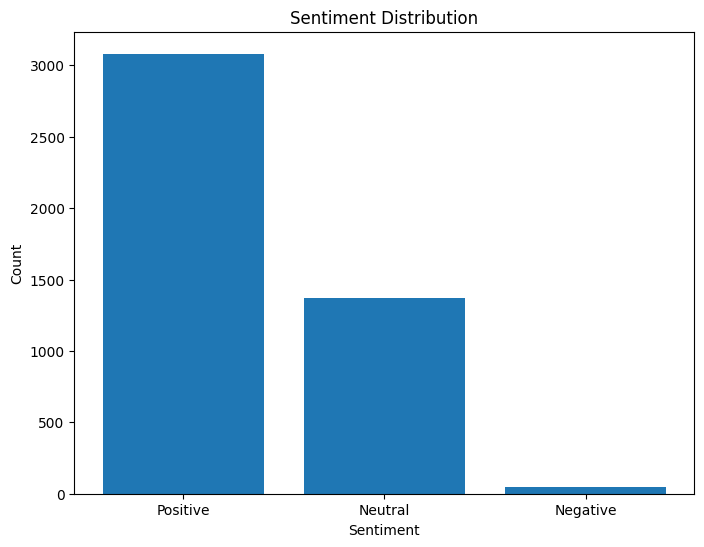

In [48]:
import matplotlib.pyplot as plt

sentiments = df_clients_reclamations['sentiment'].value_counts()

plt.figure(figsize=(8,6))
plt.bar(sentiments.index, sentiments.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [49]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [50]:
from sklearn.model_selection import train_test_split

In [51]:
X = df_clients_reclamations['cleaned_reclamation']
y = df_clients_reclamations['DESC_CLEAN_sentiment']  # replace 'sentiment_score' with your sentiment score column

# split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# create new DataFrames
df_train = pd.DataFrame(X_train, columns=['cleaned_reclamation'])
df_train['DESC_CLEAN_sentiment'] = y_train

df_val = pd.DataFrame(X_val, columns=['cleaned_reclamation'])
df_val['DESC_CLEAN_sentiment'] = y_val

In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Pre-processing of data
def text_transformation(df_col):
    corpus = []
    for item in df_col:
        new_item = re.sub('[^a-zA-Z]', ' ', str(item))
        new_item = new_item.lower()
        new_item = new_item.split()
        new_item = [lm.lemmatize(word) for word in new_item if word not in set(stopwords.words('french'))]
        corpus.append(' '.join(str(x) for x in new_item))
    return corpus

lm = WordNetLemmatizer()

# Apply pre-processing
X_train_preprocessed = text_transformation(df_train['cleaned_reclamation'])
X_val_preprocessed = text_transformation(df_val['cleaned_reclamation'])

# Vectorization
vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train_preprocessed)
X_val_vectorized = vectorizer.transform(X_val_preprocessed)

# Train the model
model = LinearRegression()
model.fit(X_train_vectorized, df_train['DESC_CLEAN_sentiment'])

# Model evaluation
y_train_pred = model.predict(X_train_vectorized)
y_val_pred = model.predict(X_val_vectorized)

train_mse = mean_squared_error(df_train['DESC_CLEAN_sentiment'], y_train_pred)
train_r2 = r2_score(df_train['DESC_CLEAN_sentiment'], y_train_pred)

val_mse = mean_squared_error(df_val['DESC_CLEAN_sentiment'], y_val_pred)
val_r2 = r2_score(df_val['DESC_CLEAN_sentiment'], y_val_pred)

print("Train MSE: ", train_mse)
print("Train R2: ", train_r2)

print("Validation MSE: ", val_mse)
print("Validation R2: ", val_r2)

In [ ]:
import matplotlib.pyplot as plt

# Plot actual sentiment scores vs. predicted sentiment scores
plt.scatter(df_train['DESC_CLEAN_sentiment'], y_train_pred)
plt.xlabel('Actual Sentiment Scores')
plt.ylabel('Predicted Sentiment Scores')
plt.title('Linear Regression Model (Training Set)')
plt.show()

plt.scatter(df_val['DESC_CLEAN_sentiment'], y_val_pred)
plt.xlabel('Actual Sentiment Scores')
plt.ylabel('Predicted Sentiment Scores')
plt.title('Linear Regression Model (Validation Set)')
plt.show()

In [ ]:
df_train['sentiment_score'] = df_train['cleaned_reclamation'].apply(lambda x: model.predict(vectorizer.transform([x]))[0])
df_val['sentiment_score'] = df_val['cleaned_reclamation'].apply(lambda x: model.predict(vectorizer.transform([x]))[0])

In [ ]:
df_train['sentiment_score']

In [ ]:
df_val['sentiment_score']

In [ ]:
def predict_sentiment_score(row):
    input_ids = vectorizer.transform([row['cleaned_reclamation']])
    return model.predict(input_ids)[0]

In [ ]:
df_clients_reclamations['sentiment_score'] = df_clients_reclamations.apply(predict_sentiment_score, axis=1)

In [ ]:
def predict_sentiment_score(row):
    input_ids = vectorizer.transform([row['cleaned_reclamation']])
    return model.predict(input_ids)[0]

df_clients_reclamations['sentiment_score'] = df_clients_reclamations.apply(predict_sentiment_score, axis=1)

print(df_clients_reclamations.head())

In [ ]:
def assign_sentiment_label(score):
    if score <= 0.0:
        return 'Negative'
    else:
        return 'Positive'

In [ ]:
df_clients_reclamations['sentiment_label'] = df_clients_reclamations['sentiment_score'].apply(assign_sentiment_label)

In [ ]:
def assign_sentiment_label(score):
    if score <= -0.5:
        return 'Negative'
    elif score < 0.5:
        return 'Neutral'
    else:
        return 'Positive'

In [ ]:
df_clients_reclamations['sentiment_label_2'] = df_clients_reclamations['sentiment_score'].apply(assign_sentiment_label)

In [ ]:
df_clients_reclamations['sentiment_label_2']

In [ ]:
df_clients_reclamations['sentiment_label']

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
from textblob import TextBlob

def textblob_sentiment_analysis(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0.5:
        return 'Positive'
    elif polarity < -0.5:
        return 'Negative'
    else:
        return 'Neutral'

In [ ]:
df_clients_reclamations['textblob_sentiment_label'] = df_clients_reclamations['cleaned_reclamation'].apply(textblob_sentiment_analysis)

In [ ]:
def textblob_sentiment_score(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

df_clients_reclamations['textblob_sentiment_score'] = df_clients_reclamations['cleaned_reclamation'].apply(textblob_sentiment_score)

In [ ]:
df_clients_reclamations['textblob_sentiment_score']

In [ ]:
df_clients_reclamations['textblob_sentiment_score'].head(60)

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
import nltk
nltk.download('vader_lexicon')
sid=SentimentIntensityAnalyzer()
ps=lambda x:sid.polarity_scores(x)
sentiment_scores_vader=df_clients_reclamations.cleaned_reclamation.apply(ps)
sentiment_scores_vader

In [ ]:
sentiment_df=pd.DataFrame(data=list(sentiment_scores_vader))
display(sentiment_df)

In [ ]:
labelize=lambda x:'neutral' if x==0 else('positive' if x>0 else 'negative')
sentiment_df['label_vader']=sentiment_df.compound.apply(labelize)
display(sentiment_df.head(10))

In [ ]:
display(df_clients_reclamations.head(5))
data=df_clients_reclamations.join(sentiment_df.label_vader)
display(data.head(5))

In [ ]:
counts_df=data.label_vader.value_counts().reset_index()
display(counts_df)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Vectorisation du texte
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(texts)

# Entraînement du modèle Naive Bayes
model = MultinomialNB()
model.fit(X, texts)  # Utilisation du texte lui-même comme cible pour une approche non supervisée

# Prédiction sur les données d'entraînement
y_pred = model.predict(X)

# Évaluation de la précision du modèle (approche non supervisée)
accuracy = accuracy_score(texts, y_pred)
print("Précision du modèle : {:.2f}".format(accuracy))

In [ ]:
#TEXTBLOB

# Analyse de sentiment pour chaque texte de la table
for index, row in data.iterrows():
    texte = row['cleaned_reclamation']
    blob = TextBlob(texte)
    polarite = blob.sentiment.polarity
    subjectivite = blob.sentiment.subjectivity

    # Affichage des résultats pour chaque texte
    print("Texte:", texte)
    print("Polarité du sentiment : ", polarite)
    print("Subjectivité du sentiment : ", subjectivite)
    print("\n")

In [ ]:

from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.pyplot as plt

# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenized_texts = [word_tokenize(text.lower()) for text in texts]

# Filtrer les mots vides (stop words)
stop_words = set(stopwords.words('french'))
filtered_texts = [[word for word in text if word.isalnum() and word not in stop_words] for text in tokenized_texts]

# Calculer la fréquence des mots
all_words = [word for text in filtered_texts for word in text]
fdist = FreqDist(all_words)

# Afficher les 10 mots les plus fréquents
print("Les 30 mots les plus fréquents :")
print(fdist.most_common(30))

# Afficher un graphique de la distribution des mots
fdist.plot(30, cumulative=False)
plt.show()

In [ ]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

In [ ]:
def analyser_reclamation(df3):

    # Tokeniser la réclamation
    mots = word_tokenize(df3)

    # Supprimer les stopwords
    mots_utiles = [mot for mot in mots if mot not in stopwords.words('french')]
    return mots_utiles

In [ ]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [ ]:
df_clients_reclamations['mots_utiles'].head(50)

In [ ]:
df_clients_reclamations.head()

In [ ]:
stop_words=set(STOP_WORDS)

deselect_stop_words = ['n\'', 'ne','pas','plus','personne','aucun','ni','aucune','rien']
for w in deselect_stop_words:
    if w in stop_words:
        stop_words.remove(w)
    else:
        continue

In [ ]:
AllfilteredREC=[]
for cleaned_reclamation in df_clients_reclamations["mots_utiles"]:
    filteredREC = [w for w in cleaned_reclamation if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredREC.append(' '.join(filteredREC))

In [ ]:
df_clients_reclamations["DESCAferPreproc"]=AllfilteredREC
df_clients_reclamations.head()

In [ ]:
texte_reclamation = df_clients_reclamations.cleaned_reclamation

In [ ]:
!python -m spacy download fr_core_news_sm

In [ ]:
nlp = spacy.load('fr_core_news_sm')
texte_reclamation = df_clients_reclamations.cleaned_reclamation

In [ ]:
docs = texte_reclamation.apply(nlp)

In [ ]:
docs.head()

In [ ]:
df_clients_reclamations.head(10)

In [ ]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [ ]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

In [ ]:
df_clients_reclamations['DESCAferPreproc'] = df_clients_reclamations['DESCAferPreproc'].str.replace('xd', '')
df_clients_reclamations['cleaned_reclamation'] = df_clients_reclamations['cleaned_reclamation'].str.replace('xd', '')

In [ ]:
def analyser_reclamation(df3):

    # Tokeniser la réclamation
    mots = word_tokenize(df3)

    # Supprimer les stopwords
    mots_utiles = [mot for mot in mots if mot not in stopwords.words('french')]
    return mots_utiles

In [ ]:
# Sélectionner les textes des réclamations
texts = df_clients_reclamations['cleaned_reclamation'].tolist()

# Tokeniser les textes
tokenizer = nltk.tokenize.word_tokenize
tokenized_texts = [tokenizer(text) for text in texts]

# Extraire les mots-clés
stop_words = set(nltk.corpus.stopwords.words('french'))
keywords = []
for text in tokenized_texts:
    for word in text:
        if word not in stop_words:
            keywords.append(word)

# Afficher les mots-clés
print(keywords)

In [ ]:
df_clients_reclamations['mots_utiles'] = df_clients_reclamations['cleaned_reclamation'].apply(analyser_reclamation)

In [ ]:
df_clients_reclamations['mots_utiles'].head(50)

In [ ]:
df_clients_reclamations.head(10)

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
def generer_num_doc(TYPDOC):
    if isinstance(TYPDOC, str):
        if 'CIN' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(8))
        elif 'Identité Fiscale' in TYPDOC or 'Registre de commerce' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(6)) + random.choice(string.ascii_uppercase)
        elif 'Passeport' in TYPDOC:
            return ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(9))
        elif 'Carte de séjour' in TYPDOC:
            return ''.join(str(np.random.randint(0, 9)) for _ in range(10))
    return None  # retourner None si TYPDOC n'est pas une chaîne
df_clients_reclamations['NUM_Doc'] = df_clients_reclamations['TYPDOC'].apply(generer_num_doc)

In [ ]:
df_clients_reclamations.NUM_Doc.head(50)

In [ ]:
df_clients_reclamations.dtypes

In [ ]:
# Générer des numéros de compte aléatoires pour toutes les réclamations
df_clients_reclamations['NUMCPT'] = df_clients_reclamations['Id_client'].apply(lambda x: random.randint(1000000000, 9999999999))

In [ ]:
df_clients_reclamations.NUMCPT.head()

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
df_clients_reclamations['NUMCPT_2'] = np.nan

In [ ]:
nombre_id_client_uniques = df_clients_reclamations['Id_client'].nunique()

In [ ]:
nombre_id_client_uniques

In [ ]:
# Sélectionner 300 ID clients aléatoires
selected_ids = np.random.choice(df_clients_reclamations['Id_client'], 300, replace=False)

In [ ]:
# Générer un deuxième numéro de compte pour les ID clients sélectionnés
df_clients_reclamations.loc[df_clients_reclamations['Id_client'].isin(selected_ids), 'NUMCPT_2'] = [random.randint(1000000000, 9999999999) for _ in range(df_clients_reclamations['Id_client'].isin(selected_ids).sum())]

In [ ]:
df_clients_reclamations.head(50)

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
df_clients_reclamations['NUMCPT_2'] = df_clients_reclamations['NUMCPT_2'].fillna(0)#remplacer NAN par 0

In [ ]:
df_clients_reclamations['NUMCPT_2'] = df_clients_reclamations['NUMCPT_2'].astype('int64')

In [ ]:
df_clients_reclamations.to_csv('clients_reclamations.csv', index=False)

In [ ]:
df_clients_reclamations.head(50)

In [ ]:
df_keywords_departments=pd.read_csv("/content/mots_cles.csv",sep=';')

In [ ]:
df_keywords_departments

In [ ]:
df_keywords_departments.columns

df_clients_reclamations_VF['Departements'] = None

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
# Créer un vectorizer TF-IDF
vectorizer = TfidfVectorizer()

# Créer un modèle KMeans pour classer les réclamations dans les départements
kmeans = KMeans(n_clusters=len(df_keywords_departments['departement'].unique()), n_init=10, random_state=0)

In [ ]:
# Pour chaque ligne du DataFrame des réclamations
for i, row in df_clients_reclamations.iterrows():
    # Si TYPE_RECLAM est 'RECLAMATION'
    if row['TYPE_RECLAM'] == 'RECLAMATION':
        # Vectoriser le contenu DESCAferPreproc
        X = vectorizer.fit_transform(df_clients_reclamations.loc[df_clients_reclamations['TYPE_RECLAM'] == 'RECLAMATION', 'DESCAferPreproc'])

        # Utiliser KMeans pour prédire le département
        predicted_department = kmeans.fit_predict(X)

        # Affecter le département convenant à la colonne 'Departements'
        df_clients_reclamations.loc[df_clients_reclamations['TYPE_RECLAM'] == 'RECLAMATION', 'Departements'] = [df_keywords_departments['departement'].unique()[i] for i in predicted_department]

UTILISATION DE GENSIM

In [ ]:
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
ref_file_path="/content/mots_cles.csv"
class NLPModule:
    def __init__(self, ref_file_path):
        # Charger le référentiel externe
        self.df_keywords_departments = pd.read_csv(ref_file_path, sep=';')
        self.model = Word2Vec(min_count=1)
        self.kmeans = KMeans(n_clusters=len(self.df_keywords_departments['departement'].unique()), random_state=0)

    def process_claim(self, claim):
        # Préparer les données pour Word2Vec
        data = [word.split() for word in claim]

        # Entraîner le modèle Word2Vec
        self.model.build_vocab(data, progress_per=10000)
        self.model.train(data, total_examples=self.model.corpus_count, epochs=self.model.epochs)

        # Obtenir le vecteur de la réclamation
        claim_vector = self.model.wv.get_vector(claim)

        # Utiliser KMeans pour prédire le département
        predicted_department = self.kmeans.fit_predict([claim_vector])

        # Retourner le département convenant
        return self.df_keywords_departments['departement'].unique()[predicted_department[0]]


In [ ]:
df_clients_reclamations

In [ ]:
# Extraire les lignes où statut_client est égal à 'Prospect'
df_prospect = df_clients_reclamations[df_clients_reclamations['Statut_client'] == 'Prospect']

In [ ]:
# Enregistrer le DataFrame extrait dans un nouveau fichier csv
df_prospect.to_csv('prospect.csv', index=False)

sentiment_label est le plus précis

In [ ]:
df_prospect.head(100)

DETECTER SI LE TYPE EST BIEN IDENTIFIE


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
class ClientProspectClassifier:
    def __init__(self, df_clients_reclamations):
        # Préparer les données
        self.vectorizer = CountVectorizer()
        X = self.vectorizer.fit_transform(df_clients_reclamations['DESCAferPreproc'])
        y = df_clients_reclamations['Type_personne']  # Assurez-vous que 'type' est la colonne qui indique si la réclamation est d'un client ou d'un prospect

        # Entraîner le modèle
        self.model = MultinomialNB()
        self.model.fit(X, y)

    def classify(self, claim):
        # Préparer la réclamation
        X = self.vectorizer.transform([claim])

        # Prédire le type
        predicted_type = self.model.predict(X)[0]

        # Vérifier si le type prédit est incorrect
        if predicted_type == 'prospect':
            return "Alerte : Le client a été incorrectement classé comme prospect."

        return "La réclamation a été correctement classée."

In [ ]:
df_clients_reclamations = df_clients_reclamations.fillna('')


In [ ]:
classifier = ClientProspectClassifier(df_clients_reclamations)

In [ ]:
# Analyser chaque réclamation dans la colonne de réclamations
results = []
for claim in df_clients_reclamations['DESCAferPreproc']:
    alert = classifier.classify(claim)
    results.append(alert)

# Print the results
for result in results:
    print(result)


In [ ]:
df_clients_reclamations.to_csv('prospect.csv', index=False)

CONNECTION AVEC **mongoDB**

In [ ]:
pip install pymongo

In [ ]:
import pymongo

In [ ]:
from pymongo import MongoClient